https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1

In [1]:
import pandas as pd
import numpy as np

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pickle

from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from tqdm import trange

import matplotlib.pyplot as plt
from torch.optim import RMSprop



%load_ext autoreload
%autoreload 2
from help_tool import help_tool

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070 Ti'

In [3]:
df = pd.read_csv(r'Archive\clean_data.csv').drop(columns='Unnamed: 0')

In [4]:
cols = df.columns
label_cols = list(cols[2:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [5]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [6]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,d6a0db6e2046e32d,proposed deletions answered query talk page th...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,0f1859651c21cf42,thank answered question consistent style requi...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,ddbe79b725b7abab,moreover explained elsewhere given every demog...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,fb1994d28ea800a0,power block power block,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,d1f4165fa821664a,well right removing points finger towards let ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [7]:
df.shape

(157572, 9)

In [8]:
df = df.sample(70000, random_state=42).reset_index()

In [9]:
labels = list(df.one_hot_labels.values)
comments = list(df.comment_text.values)

In [10]:
max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
encodings = tokenizer.batch_encode_plus(comments, max_length=max_length, pad_to_max_length=True, truncation=True)

print('tokenizer outputs: ', encodings.keys())


c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for 

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


Since RobertaTokenizer is designed for use with the RoBERTa model, and RoBERTa does not use token_type_ids, these are not included in the output of batch_encode_plus. The presence of input_ids and attention_mask is sufficient for using RoBERTa.

In [11]:
print('tokenizer outputs: ', encodings.keys())

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [12]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

In [13]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df['one_hot_labels'].astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df['one_hot_labels'].astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [39377, 38715, 23492]


In [14]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [15]:
print(len(input_ids))
print(len(labels))
print(len(attention_masks))

69997
69997
69997


# Dataloaders

In [62]:
batch_size = 32

In [64]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids, labels, attention_masks,
    random_state=42, test_size=0.1, stratify=labels
)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

In [66]:
train_dataloader = help_tool.sequential_sampler_dataloader_creation(batch_size, train_inputs, train_labels, train_masks)
validation_dataloader = help_tool.sequential_sampler_dataloader_creation(batch_size, validation_inputs, validation_labels, validation_masks)

torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [65]:
validation_dataloader = help_tool.sequential_sampler_dataloader_creation(batch_size, validation_inputs, validation_labels, validation_masks)

In [16]:
# # Use train_test_split to split our data into train and validation sets

# train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
#     input_ids, labels, attention_masks,
#     random_state=42, test_size=0.1, stratify=labels
# )

# # Add one frequency data to train data
# train_inputs.extend(one_freq_input_ids)
# train_labels.extend(one_freq_labels)
# train_masks.extend(one_freq_attention_masks)

# # Convert all of our data into torch tensors, the required datatype for our model
# train_inputs = torch.tensor(train_inputs)
# train_labels = torch.tensor(train_labels)
# train_masks = torch.tensor(train_masks)

# validation_inputs = torch.tensor(validation_inputs)
# validation_labels = torch.tensor(validation_labels)
# validation_masks = torch.tensor(validation_masks)


C:\Users\User\AppData\Local\Temp\ipykernel_2840\877207265.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  train_labels = torch.tensor(train_labels)


In [17]:
# # Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
# batch_size = 32

# # Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# # with an iterator the entire dataset does not need to be loaded into memory

# train_data = TensorDataset(train_inputs, train_masks, train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
# validation_sampler = SequentialSampler(validation_data)
# validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Test data

In [57]:
test_df = pd.read_csv('Archive/test.csv')
test_labels_df = pd.read_csv('Archive/test_labels.csv')
test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])
print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same


test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

Null values:  False
Same columns between train and test:  True


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [67]:
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.comment_text.values)

# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length, padding=True, truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

test_dataloader = help_tool.sequential_sampler_dataloader_creation(batch_size, test_input_ids, test_labels, test_attention_masks)

torch.save(test_dataloader,'test_data_loader')

# Roberta Model and parameters

In [19]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [20]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Sigmoid Activation Function with RM Stop Optimizer
## Training
BCEWithLogitsLoss stands for Binary Cross Entropy with Logits Loss. It is a combination of two components:

Sigmoid Activation: Applies the sigmoid function to the logits (raw outputs) to convert them into probabilities.
Binary Cross Entropy Loss: Computes the binary cross-entropy loss between the predicted probabilities and the true binary labels.

In [21]:
# Define RMSprop optimizer
optimizer = RMSprop(optimizer_grouped_parameters, lr=2e-5, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)

Epoch:  33%|███▎      | 1/3 [14:33<29:07, 873.95s/it]

Epoch 1 - Training Loss: 0.0828, Training Accuracy: 90.71%, Validation Loss: 0.0659, Validation Accuracy: 91.51%


Epoch:  67%|██████▋   | 2/3 [29:08<14:34, 874.06s/it]

Epoch 2 - Training Loss: 0.0822, Training Accuracy: 90.77%, Validation Loss: 0.0743, Validation Accuracy: 91.66%


Epoch: 100%|██████████| 3/3 [43:42<00:00, 874.18s/it]

Epoch 3 - Training Loss: 0.0793, Training Accuracy: 90.91%, Validation Loss: 0.0875, Validation Accuracy: 91.56%


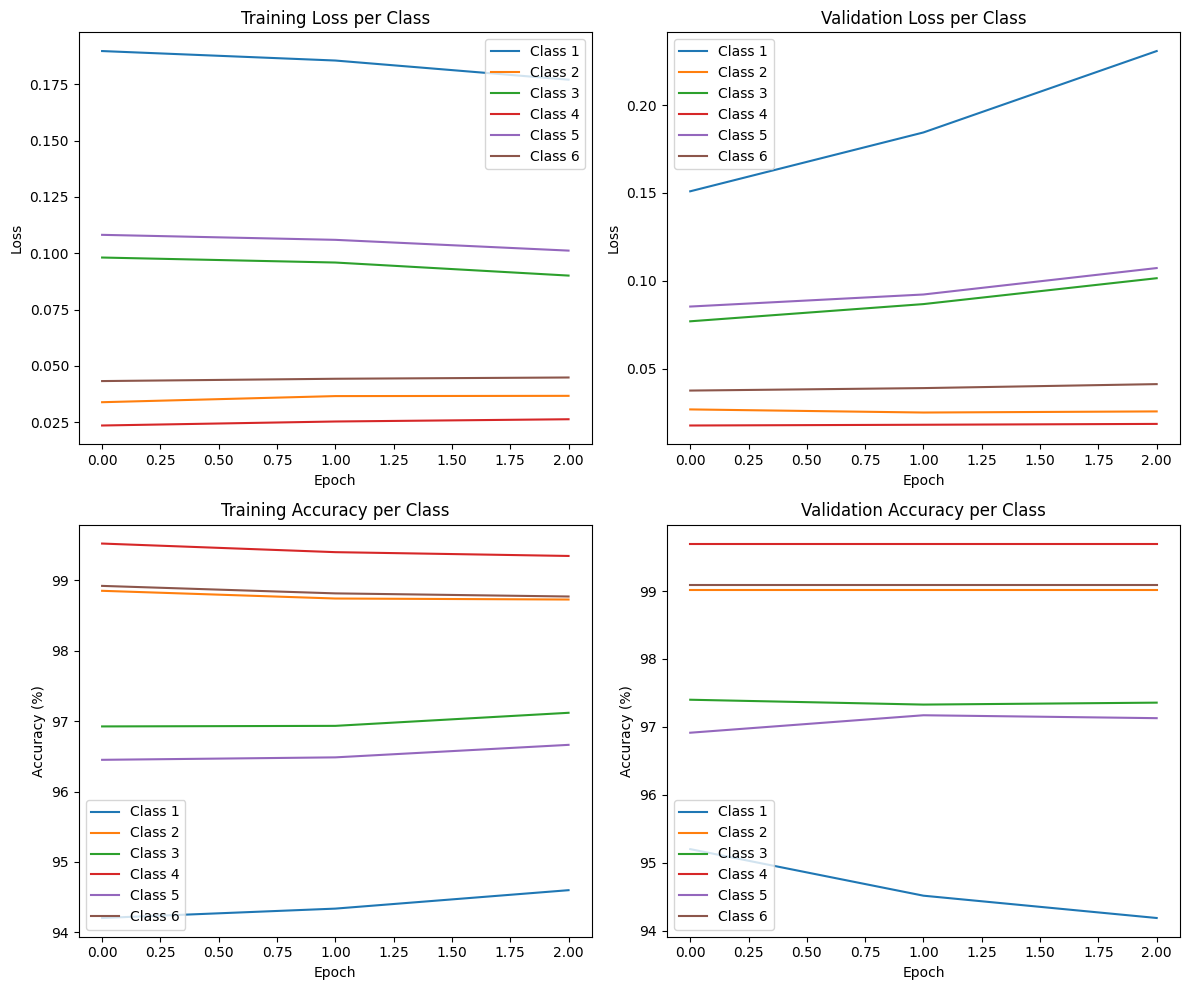

In [24]:
# Initialize lists to store metrics for each epoch and each class
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []

train_loss_per_class = {i: [] for i in range(num_labels)}  # num_labels is 6 in your case
val_loss_per_class = {i: [] for i in range(num_labels)}
train_accuracy_per_class = {i: [] for i in range(num_labels)}
val_accuracy_per_class = {i: [] for i in range(num_labels)}

epochs = 3

for epoch in trange(epochs, desc="Epoch"):

    # Training
    model.train()
    total_train_loss = 0
    logit_preds_train, true_labels_train = [], []

    per_class_train_loss = np.zeros(num_labels)  # Track loss per class
    per_class_train_correct = np.zeros(num_labels)  # Track correct predictions per class
    per_class_train_total = np.zeros(num_labels)  # Track total samples per class

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]

        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1, num_labels), b_labels.type_as(logits).view(-1, num_labels))

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred_labels_train = torch.sigmoid(logits)
        logit_preds_train.append(pred_labels_train.detach().cpu().numpy())
        true_labels_train.append(b_labels.detach().cpu().numpy())

        # Per-class loss and accuracy tracking
        for i in range(num_labels):
            per_class_train_loss[i] += loss_func(logits[:, i], b_labels[:, i].type_as(logits)).item()  # Loss per class
            
            # Convert to numpy arrays for proper comparison
            pred_bools_per_class = (pred_labels_train[:, i] > 0.5).cpu().numpy()  # Boolean prediction for class
            true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)  # Ground truth for class

            # Sum correct predictions
            per_class_train_correct[i] += np.sum(pred_bools_per_class == true_bools_per_class)  # Correct preds per class
            per_class_train_total[i] += len(true_bools_per_class)  # Total samples per class


    # Calculate average training loss and accuracy for each class
    for i in range(num_labels):
        train_loss_per_class[i].append(per_class_train_loss[i] / len(train_dataloader))
        train_accuracy_per_class[i].append(100 * per_class_train_correct[i] / per_class_train_total[i])

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_per_epoch.append(avg_train_loss)

    flat_pred_labels_train = [item for sublist in logit_preds_train for item in sublist]
    flat_true_labels_train = [item for sublist in true_labels_train for item in sublist]

    pred_bools_train = [pl > 0.5 for pl in flat_pred_labels_train]
    true_bools_train = [tl == 1 for tl in flat_true_labels_train]

    train_accuracy = accuracy_score(true_bools_train, pred_bools_train) * 100
    train_accuracy_per_epoch.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    logit_preds, true_labels = [], []

    per_class_val_loss = np.zeros(num_labels)
    per_class_val_correct = np.zeros(num_labels)
    per_class_val_total = np.zeros(num_labels)

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            pred_labels = torch.sigmoid(logits)

            loss_func = BCEWithLogitsLoss()
            loss = loss_func(logits.view(-1, num_labels), b_labels.type_as(logits).view(-1, num_labels))
            total_val_loss += loss.item()

            logit_preds.append(pred_labels.detach().cpu().numpy())
            true_labels.append(b_labels.detach().cpu().numpy())

            # Per-class validation loss and accuracy tracking
            for i in range(num_labels):
                per_class_val_loss[i] += loss_func(logits[:, i], b_labels[:, i].type_as(logits)).item()  # Loss per class
                
                # Convert to numpy arrays for proper comparison
                pred_bools_per_class = (pred_labels[:, i] > 0.5).cpu().numpy()  # Boolean prediction for class
                true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)  # Ground truth for class

                # Sum correct predictions
                per_class_val_correct[i] += np.sum(pred_bools_per_class == true_bools_per_class)  # Correct preds per class
                per_class_val_total[i] += len(true_bools_per_class)  # Total samples per class


    for i in range(num_labels):
        val_loss_per_class[i].append(per_class_val_loss[i] / len(validation_dataloader))
        val_accuracy_per_class[i].append(100 * per_class_val_correct[i] / per_class_val_total[i])

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_loss_per_epoch.append(avg_val_loss)

    flat_pred_labels = [item for sublist in logit_preds for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    pred_bools = [pl > 0.5 for pl in flat_pred_labels]
    true_bools = [tl == 1 for tl in flat_true_labels]

    val_accuracy = accuracy_score(true_bools, pred_bools) * 100
    val_accuracy_per_epoch.append(val_accuracy)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")



help_tool.plot_per_class(num_labels, train_loss_per_class, val_loss_per_class, train_accuracy_per_class, val_accuracy_per_class)


torch.save(model.state_dict(), 'model_RMSprop_per_class')

RM Stop took 43min

## Optimizing threshold value for F1 score 

In [69]:
(tokenized_texts, pred_labels, true_bools) = help_tool.predictions(model, device, validation_dataloader)
help_tool.optimize_threshold(pred_labels, true_bools, label_cols)

Best Threshold:  0.21000000000000002
Test F1:  0.62
Test Accuracy:  0.91 

               precision    recall  f1-score   support

        toxic       0.94      0.49      0.64       659
 severe_toxic       0.32      0.68      0.43        69
      obscene       0.83      0.66      0.73       371
       threat       0.00      0.00      0.00        21
       insult       0.75      0.61      0.68       348
identity_hate       0.17      0.34      0.23        64

    micro avg       0.71      0.55      0.62      1532
    macro avg       0.50      0.46      0.45      1532
 weighted avg       0.80      0.55      0.64      1532
  samples avg       0.04      0.04      0.04      1532



## Test data

In [78]:
help_tool.altered_tresshold_classification_report(model, device, test_dataloader, test_label_cols, 0.21)

F1:  0.48
Accuracy:  0.89 

               precision    recall  f1-score   support

        toxic       0.65      0.42      0.51      6090
 severe_toxic       0.17      0.37      0.23       367
      obscene       0.73      0.45      0.55      3691
       threat       0.00      0.00      0.00       211
       insult       0.64      0.40      0.49      3427
identity_hate       0.16      0.15      0.15       712

    micro avg       0.59      0.40      0.48     14498
    macro avg       0.39      0.30      0.32     14498
 weighted avg       0.62      0.40      0.48     14498
  samples avg       0.03      0.03      0.03     14498



# Sigmoid Activation with AdamW Optimizer

In [79]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=True, no_deprecation_warning=True)

Epoch:  33%|███▎      | 1/3 [14:43<29:26, 883.08s/it]

Epoch 1 - Training Loss: 0.0684, Training Accuracy: 91.19%, Validation Loss: 0.0620, Validation Accuracy: 91.91%


Epoch:  67%|██████▋   | 2/3 [29:22<14:41, 881.01s/it]

Epoch 2 - Training Loss: 0.0614, Training Accuracy: 91.42%, Validation Loss: 0.0606, Validation Accuracy: 91.90%


Epoch: 100%|██████████| 3/3 [43:52<00:00, 877.52s/it]

Epoch 3 - Training Loss: 0.0559, Training Accuracy: 91.69%, Validation Loss: 0.0606, Validation Accuracy: 92.06%


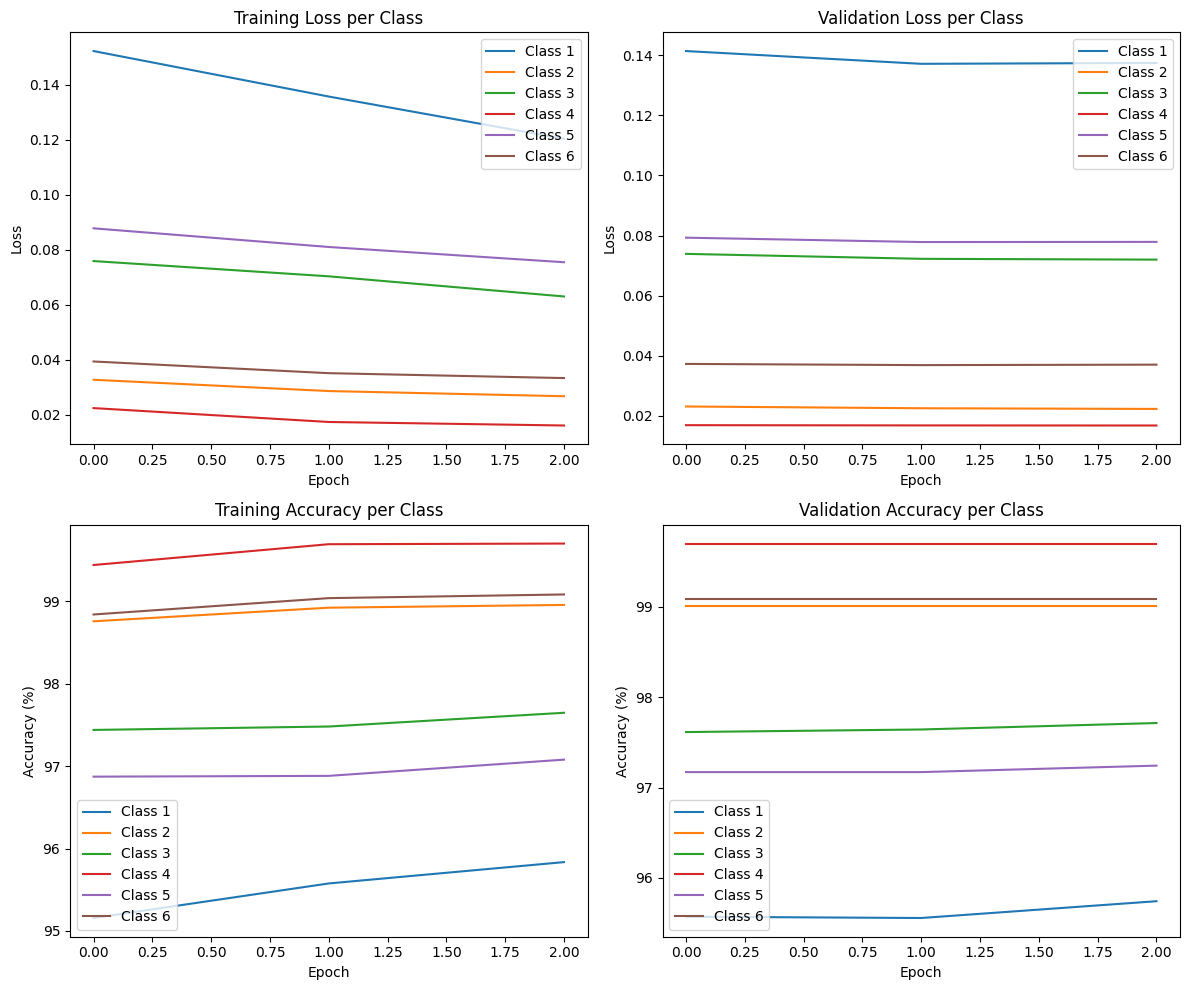

In [80]:
# Initialize lists to store metrics for each epoch and each class
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []

train_loss_per_class = {i: [] for i in range(num_labels)}  # num_labels is 6 in your case
val_loss_per_class = {i: [] for i in range(num_labels)}
train_accuracy_per_class = {i: [] for i in range(num_labels)}
val_accuracy_per_class = {i: [] for i in range(num_labels)}

epochs = 3

for epoch in trange(epochs, desc="Epoch"):

    # Training
    model.train()
    total_train_loss = 0
    logit_preds_train, true_labels_train = [], []

    per_class_train_loss = np.zeros(num_labels)  # Track loss per class
    per_class_train_correct = np.zeros(num_labels)  # Track correct predictions per class
    per_class_train_total = np.zeros(num_labels)  # Track total samples per class

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]

        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1, num_labels), b_labels.type_as(logits).view(-1, num_labels))

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred_labels_train = torch.sigmoid(logits)
        logit_preds_train.append(pred_labels_train.detach().cpu().numpy())
        true_labels_train.append(b_labels.detach().cpu().numpy())

        # Per-class loss and accuracy tracking
        for i in range(num_labels):
            per_class_train_loss[i] += loss_func(logits[:, i], b_labels[:, i].type_as(logits)).item()  # Loss per class
            
            # Convert to numpy arrays for proper comparison
            pred_bools_per_class = (pred_labels_train[:, i] > 0.5).cpu().numpy()  # Boolean prediction for class
            true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)  # Ground truth for class

            # Sum correct predictions
            per_class_train_correct[i] += np.sum(pred_bools_per_class == true_bools_per_class)  # Correct preds per class
            per_class_train_total[i] += len(true_bools_per_class)  # Total samples per class


    # Calculate average training loss and accuracy for each class
    for i in range(num_labels):
        train_loss_per_class[i].append(per_class_train_loss[i] / len(train_dataloader))
        train_accuracy_per_class[i].append(100 * per_class_train_correct[i] / per_class_train_total[i])

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_per_epoch.append(avg_train_loss)

    flat_pred_labels_train = [item for sublist in logit_preds_train for item in sublist]
    flat_true_labels_train = [item for sublist in true_labels_train for item in sublist]

    pred_bools_train = [pl > 0.5 for pl in flat_pred_labels_train]
    true_bools_train = [tl == 1 for tl in flat_true_labels_train]

    train_accuracy = accuracy_score(true_bools_train, pred_bools_train) * 100
    train_accuracy_per_epoch.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    logit_preds, true_labels = [], []

    per_class_val_loss = np.zeros(num_labels)
    per_class_val_correct = np.zeros(num_labels)
    per_class_val_total = np.zeros(num_labels)

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            pred_labels = torch.sigmoid(logits)

            loss_func = BCEWithLogitsLoss()
            loss = loss_func(logits.view(-1, num_labels), b_labels.type_as(logits).view(-1, num_labels))
            total_val_loss += loss.item()

            logit_preds.append(pred_labels.detach().cpu().numpy())
            true_labels.append(b_labels.detach().cpu().numpy())

            # Per-class validation loss and accuracy tracking
            for i in range(num_labels):
                per_class_val_loss[i] += loss_func(logits[:, i], b_labels[:, i].type_as(logits)).item()  # Loss per class
                
                # Convert to numpy arrays for proper comparison
                pred_bools_per_class = (pred_labels[:, i] > 0.5).cpu().numpy()  # Boolean prediction for class
                true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)  # Ground truth for class

                # Sum correct predictions
                per_class_val_correct[i] += np.sum(pred_bools_per_class == true_bools_per_class)  # Correct preds per class
                per_class_val_total[i] += len(true_bools_per_class)  # Total samples per class


    for i in range(num_labels):
        val_loss_per_class[i].append(per_class_val_loss[i] / len(validation_dataloader))
        val_accuracy_per_class[i].append(100 * per_class_val_correct[i] / per_class_val_total[i])

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_loss_per_epoch.append(avg_val_loss)

    flat_pred_labels = [item for sublist in logit_preds for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    pred_bools = [pl > 0.5 for pl in flat_pred_labels]
    true_bools = [tl == 1 for tl in flat_true_labels]

    val_accuracy = accuracy_score(true_bools, pred_bools) * 100
    val_accuracy_per_epoch.append(val_accuracy)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")



help_tool.plot_per_class(num_labels, train_loss_per_class, val_loss_per_class, train_accuracy_per_class, val_accuracy_per_class)


torch.save(model.state_dict(), 'model_AdamW_per_class')

AdamW took 43min

## Optimizing threshold value for F1 score 

In [81]:
(tokenized_texts, pred_labels, true_bools) = help_tool.predictions(model, device, validation_dataloader)
help_tool.optimize_threshold(pred_labels, true_bools, label_cols)

Best Threshold:  0.33
F1:  0.71
Accuracy:  0.92 

               precision    recall  f1-score   support

        toxic       0.84      0.68      0.75       659
 severe_toxic       0.41      0.65      0.50        69
      obscene       0.79      0.77      0.78       371
       threat       0.00      0.00      0.00        21
       insult       0.69      0.72      0.70       348
identity_hate       0.00      0.00      0.00        64

    micro avg       0.75      0.67      0.71      1532
    macro avg       0.46      0.47      0.46      1532
 weighted avg       0.73      0.67      0.70      1532
  samples avg       0.05      0.06      0.05      1532



## Test data

In [85]:
help_tool.altered_tresshold_classification_report(model, device, test_dataloader, test_label_cols, 0.33)

F1:  0.39
Accuracy:  0.67 

               precision    recall  f1-score   support

        toxic       0.23      0.84      0.36      6090
 severe_toxic       0.26      0.29      0.27       367
      obscene       0.33      0.72      0.45      3691
       threat       0.00      0.00      0.00       211
       insult       0.31      0.69      0.43      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.27      0.71      0.39     14498
    macro avg       0.19      0.42      0.25     14498
 weighted avg       0.26      0.71      0.38     14498
  samples avg       0.07      0.07      0.06     14498



## Conclusion
Best optimizer is RM Stop

# Weighted BCE

In [86]:
optimizer = RMSprop(optimizer_grouped_parameters, lr=2e-5, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)

Epoch:  33%|███▎      | 1/3 [14:47<29:35, 887.95s/it]

Epoch 1 - Training Loss: 0.3885, Training Accuracy: 80.57%, Validation Loss: 0.3386, Validation Accuracy: 84.90%


Epoch:  67%|██████▋   | 2/3 [29:35<14:47, 887.69s/it]

Epoch 2 - Training Loss: 0.3451, Training Accuracy: 81.72%, Validation Loss: 0.3263, Validation Accuracy: 83.56%


Epoch: 100%|██████████| 3/3 [44:24<00:00, 888.09s/it]

Epoch 3 - Training Loss: 0.3350, Training Accuracy: 82.01%, Validation Loss: 0.3362, Validation Accuracy: 86.16%


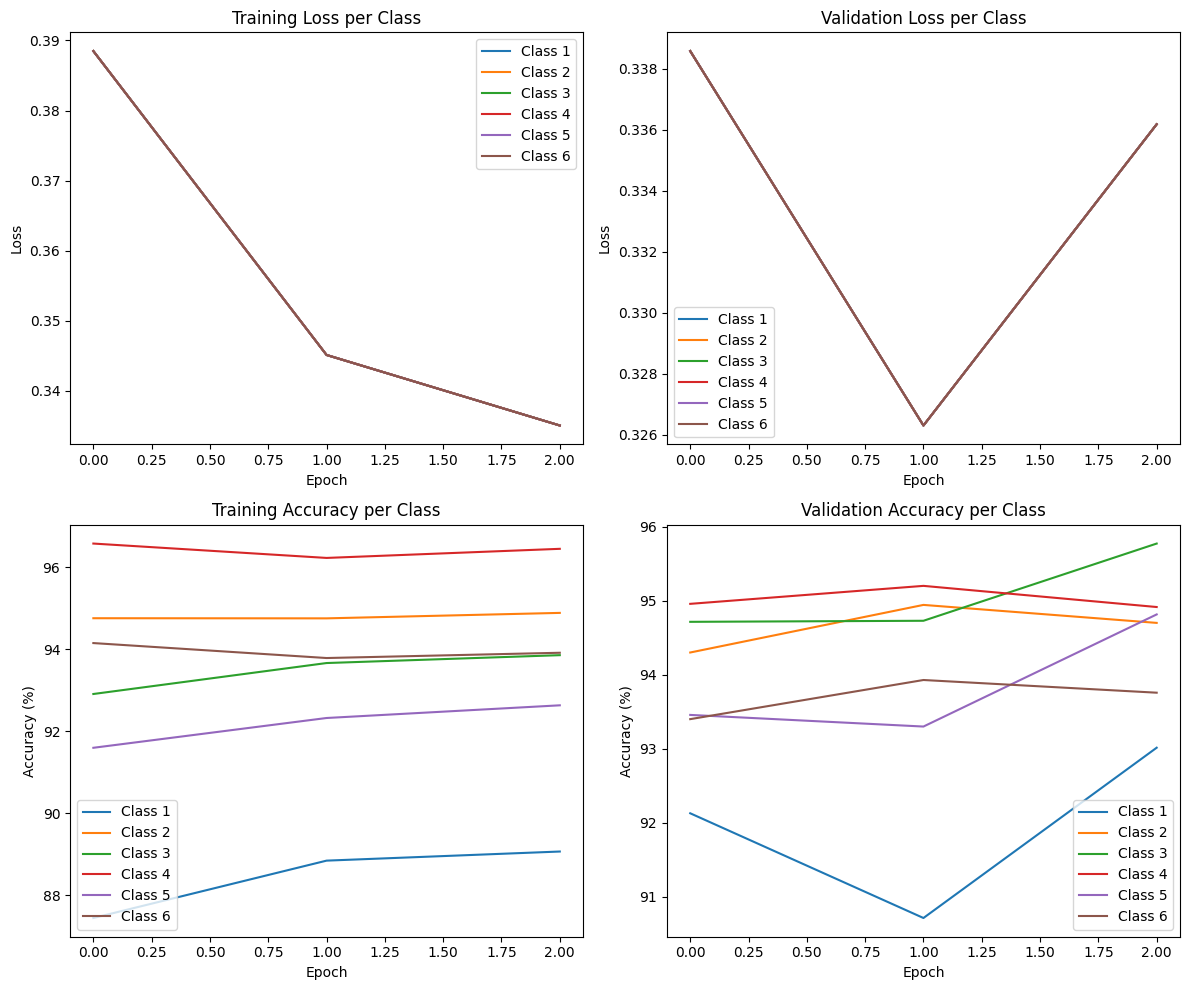

In [90]:
# Initialize lists to store metrics for each epoch and each class
train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []

train_loss_per_class = {i: [] for i in range(num_labels)}  # num_labels is 6 in your case
val_loss_per_class = {i: [] for i in range(num_labels)}
train_accuracy_per_class = {i: [] for i in range(num_labels)}
val_accuracy_per_class = {i: [] for i in range(num_labels)}

# Function to calculate class weights for Weighted BCE
def calculate_class_weights(labels):
    # Compute the number of positive and negative examples for each class
    positive_samples = labels.sum(axis=0)
    negative_samples = labels.shape[0] - positive_samples
    class_weights = negative_samples / (positive_samples + 1e-5)  # Avoid division by zero
    return torch.tensor(class_weights, dtype=torch.float).to(device)

epochs = 3

for epoch in trange(epochs, desc="Epoch"):
    # Training
    model.train()
    total_train_loss = 0
    logit_preds_train, true_labels_train = [], []

    per_class_train_loss = np.zeros(num_labels)  # Track loss per class
    per_class_train_correct = np.zeros(num_labels)  # Track correct predictions per class
    per_class_train_total = np.zeros(num_labels)  # Track total samples per class

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]  # Shape: (batch_size, num_labels)

        # Calculate class weights for Weighted BCE
        class_weights = calculate_class_weights(b_labels.cpu().numpy())
        
        # Define weighted BCE loss function
        loss_func = BCEWithLogitsLoss(pos_weight=class_weights)
        loss = loss_func(logits.view(-1, num_labels), b_labels.type_as(logits).view(-1, num_labels))  # Calculate batch loss

        total_train_loss += loss.item()  # Track total loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Predictions
        pred_labels_train = torch.sigmoid(logits)
        logit_preds_train.append(pred_labels_train.detach().cpu().numpy())
        true_labels_train.append(b_labels.detach().cpu().numpy())

        # Per-class accuracy tracking
        for i in range(num_labels):
            # Convert to numpy arrays for proper comparison
            pred_bools_per_class = (pred_labels_train[:, i] > 0.5).cpu().numpy()  # Boolean prediction for class
            true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)  # Ground truth for class

            # Sum correct predictions
            per_class_train_correct[i] += np.sum(pred_bools_per_class == true_bools_per_class)  # Correct preds per class
            per_class_train_total[i] += len(true_bools_per_class)  # Total samples per class

    # Calculate average training loss and accuracy for each class
    for i in range(num_labels):
        train_loss_per_class[i].append(total_train_loss / len(train_dataloader))  # Average loss per class
        train_accuracy_per_class[i].append(100 * per_class_train_correct[i] / per_class_train_total[i])

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_per_epoch.append(avg_train_loss)

    # Flatten predictions and true labels for overall training accuracy
    flat_pred_labels_train = [item for sublist in logit_preds_train for item in sublist]
    flat_true_labels_train = [item for sublist in true_labels_train for item in sublist]

    pred_bools_train = [pl > 0.5 for pl in flat_pred_labels_train]
    true_bools_train = [tl == 1 for tl in flat_true_labels_train]

    train_accuracy = accuracy_score(true_bools_train, pred_bools_train) * 100
    train_accuracy_per_epoch.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    logit_preds, true_labels = [], []

    per_class_val_correct = np.zeros(num_labels)
    per_class_val_total = np.zeros(num_labels)

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            pred_labels = torch.sigmoid(logits)

            # Use the same class weights for validation
            class_weights = calculate_class_weights(b_labels.cpu().numpy())
            loss_func = BCEWithLogitsLoss(pos_weight=class_weights)
            loss = loss_func(logits.view(-1, num_labels), b_labels.type_as(logits).view(-1, num_labels))
            total_val_loss += loss.item()

            logit_preds.append(pred_labels.detach().cpu().numpy())
            true_labels.append(b_labels.detach().cpu().numpy())

            # Per-class validation accuracy tracking
            for i in range(num_labels):
                pred_bools_per_class = (pred_labels[:, i] > 0.5).cpu().numpy()  # Boolean prediction for class
                true_bools_per_class = (b_labels[:, i].detach().cpu().numpy() == 1)  # Ground truth for class

                per_class_val_correct[i] += np.sum(pred_bools_per_class == true_bools_per_class)  # Correct preds per class
                per_class_val_total[i] += len(true_bools_per_class)  # Total samples per class

    # Calculate average validation loss and accuracy for each class
    for i in range(num_labels):
        val_loss_per_class[i].append(total_val_loss / len(validation_dataloader))
        val_accuracy_per_class[i].append(100 * per_class_val_correct[i] / per_class_val_total[i])

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_loss_per_epoch.append(avg_val_loss)

    flat_pred_labels = [item for sublist in logit_preds for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    pred_bools = [pl > 0.5 for pl in flat_pred_labels]
    true_bools = [tl == 1 for tl in flat_true_labels]

    val_accuracy = accuracy_score(true_bools, pred_bools) * 100
    val_accuracy_per_epoch.append(val_accuracy)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot the per-class performance metrics using your plotting function
help_tool.plot_per_class(num_labels, train_loss_per_class, val_loss_per_class, train_accuracy_per_class, val_accuracy_per_class)


torch.save(model.state_dict(), 'model_RMSprop_WeightedBCELoss_per_class')

44min

## Optimizing threshold value for F1 score 

In [91]:
(tokenized_texts, pred_labels, true_bools) = help_tool.predictions(model, device, validation_dataloader)
help_tool.optimize_threshold(pred_labels, true_bools, label_cols)

Best Threshold:  0.94
F1:  0.66
Accuracy:  0.91 

               precision    recall  f1-score   support

        toxic       0.90      0.55      0.68       659
 severe_toxic       0.26      0.83      0.39        69
      obscene       0.76      0.78      0.77       371
       threat       0.00      0.00      0.00        21
       insult       0.68      0.73      0.70       348
identity_hate       0.14      0.02      0.03        64

    micro avg       0.70      0.63      0.66      1532
    macro avg       0.46      0.48      0.43      1532
 weighted avg       0.74      0.63      0.66      1532
  samples avg       0.04      0.05      0.04      1532



## Test data

In [93]:
help_tool.altered_tresshold_classification_report(model, device, test_dataloader, test_label_cols, 0.94)

F1:  0.43
Accuracy:  0.82 

               precision    recall  f1-score   support

        toxic       0.37      0.65      0.47      6090
 severe_toxic       0.12      0.50      0.20       367
      obscene       0.32      0.76      0.45      3691
       threat       0.00      0.00      0.00       211
       insult       0.30      0.69      0.42      3427
identity_hate       0.03      0.00      0.00       712

    micro avg       0.32      0.64      0.43     14498
    macro avg       0.19      0.43      0.26     14498
 weighted avg       0.31      0.64      0.42     14498
  samples avg       0.05      0.06      0.05     14498



# Tahn Activation?